# Train a VAE on MNIST

## Setup


Import libraries

In [1]:
import importlib
import regene_models
importlib.reload(regene_models)
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
import new_CLUE
importlib.reload(new_CLUE)

<module 'new_CLUE' from '/Users/conor/Documents/College terms/College/Thesis/Thesis_Code_Minimised/MyImplementation/new_CLUE.py'>

Set the device

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")

print(f"Using device: {device}")

Using device: mps


Load the Datasets

In [3]:
# Load the MNIST dataset
transform = transforms.Compose([transforms.ToTensor()])
trainset = torchvision.datasets.MNIST(root='../data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

Set the latent dimension

In [4]:
latent_dim = 256

Create a models directory if it doesn't exist

In [5]:
# Create models directory if it doesn't exist
os.makedirs('models', exist_ok=True)

## Train the VAE

Create the model

In [6]:
from mnist_vae import VAE

# Create model instance
vae = VAE(latent_dim=latent_dim, device=device)


And train it

In [8]:
# Loss function
def loss_function(recon_x, x, mu, log_var):
    # Reconstruction loss (binary cross entropy)
    BCE = nn.functional.binary_cross_entropy(recon_x, x, reduction='sum')
    
    # KL divergence loss
    KLD = -0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
    
    return BCE + KLD

# Optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

# Training loop
num_epochs = 12
for epoch in range(num_epochs):
    vae.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(trainloader):
        data = data.to(device)
        optimizer.zero_grad()
        
        # Forward pass
        recon_batch, mu, log_var = vae(data)
        
        # Calculate loss
        loss = loss_function(recon_batch, data, mu, log_var)
        
        # Backward pass and optimize
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        
        if batch_idx % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}] Batch [{batch_idx}/{len(trainloader)}] Loss: {loss.item()/len(data):.4f}')
    
    # Print epoch statistics
    avg_loss = train_loss / len(trainloader.dataset)
    print(f'====> Epoch: {epoch+1} Average loss: {avg_loss:.4f}')
    
    # Save model checkpoint
    if (epoch + 1) % 10 == 0:
        torch.save(vae.state_dict(), f'models/vae_epoch_{epoch+1}.pt')

print("Training completed!")

# Save final model
torch.save(vae.state_dict(), 'models/vae_final.pt')


Epoch [1/12] Batch [0/938] Loss: 1234.2382
Epoch [1/12] Batch [100/938] Loss: 216.5683
Epoch [1/12] Batch [200/938] Loss: 184.5792
Epoch [1/12] Batch [300/938] Loss: 168.9657
Epoch [1/12] Batch [400/938] Loss: 159.8295
Epoch [1/12] Batch [500/938] Loss: 152.7459
Epoch [1/12] Batch [600/938] Loss: 144.7394
Epoch [1/12] Batch [700/938] Loss: 139.1952
Epoch [1/12] Batch [800/938] Loss: 146.6803
Epoch [1/12] Batch [900/938] Loss: 138.3609
====> Epoch: 1 Average loss: 176.5439
Epoch [2/12] Batch [0/938] Loss: 128.5566
Epoch [2/12] Batch [100/938] Loss: 141.1728
Epoch [2/12] Batch [200/938] Loss: 131.0402
Epoch [2/12] Batch [300/938] Loss: 126.6666
Epoch [2/12] Batch [400/938] Loss: 122.9312
Epoch [2/12] Batch [500/938] Loss: 121.6658
Epoch [2/12] Batch [600/938] Loss: 121.6311
Epoch [2/12] Batch [700/938] Loss: 115.6106
Epoch [2/12] Batch [800/938] Loss: 118.4336
Epoch [2/12] Batch [900/938] Loss: 114.5426
====> Epoch: 2 Average loss: 123.6270
Epoch [3/12] Batch [0/938] Loss: 120.4699
Epoch

KeyboardInterrupt: 

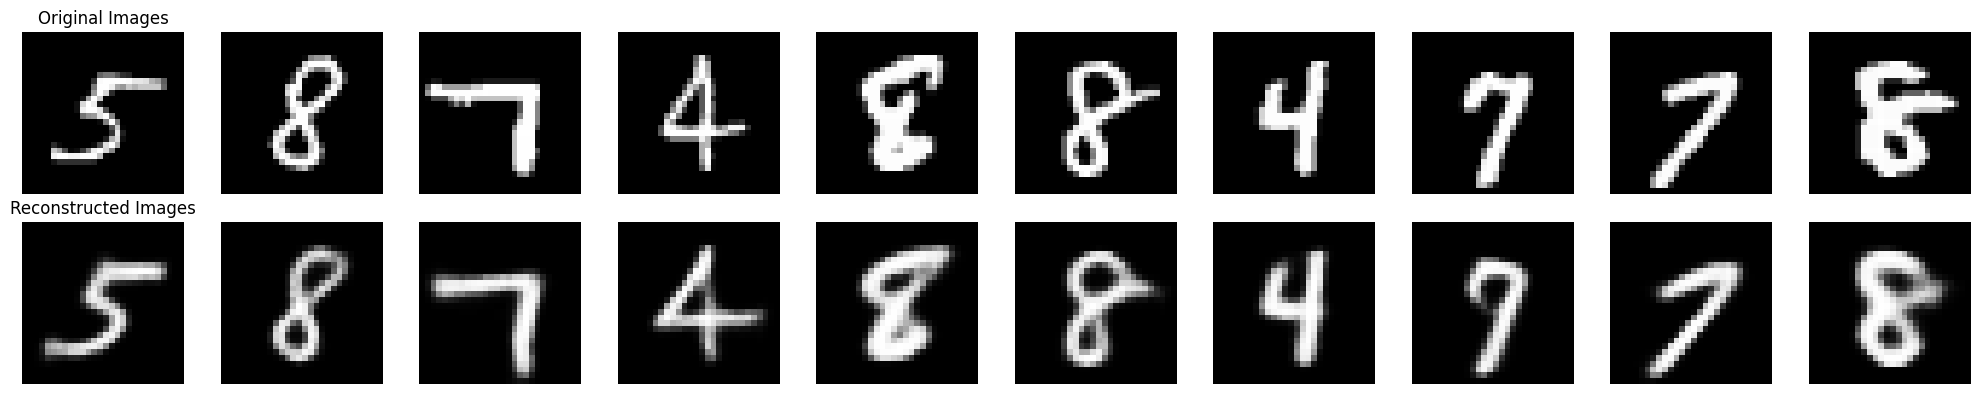

In [10]:
# Test reconstructions
vae.eval()
with torch.no_grad():
    # Get a batch of test data
    test_data, _ = next(iter(trainloader))
    test_data = test_data.to(device)
    
    # Generate reconstructions
    recon_data, _, _ = vae(test_data)
    
    # Plot original and reconstructed images
    n = 10  # Number of images to display
    plt.figure(figsize=(20, 4))
    for i in range(n):
        # Original images
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(test_data[i].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Original Images')
            
        # Reconstructed images
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(recon_data[i].cpu().squeeze().numpy(), cmap='gray')
        plt.axis('off')
        if i == 0:
            plt.title('Reconstructed Images')
            
    plt.tight_layout()
    plt.show()


In [13]:
torch.save(vae.state_dict(), 'models/mnist_vae.pth')
